In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.ticker as ticker
import pickle

# インストール方法 https://tkstock.site/2018/08/22/post-593/
import talib as ta

### data load

In [7]:
# 元データに以下２列を追加したデータを用意してください
# is_train列：trainデータ＝True
# pred列：予測結果
# 読み込むデータが正しければ後続のスクリプトは修正なしで動くと思います
col = ['is_train','Date','eurusd_Open', 'eurusd_High', 'eurusd_Low', 'eurusd_Close', 'usdjpy_Close', 'Maguro', 'pred']
df = pd.read_csv('../output/df_back_test.csv')[col]

df_train_result = df[df['is_train']]
df_test_result = df[~df['is_train']]
print(df.shape)
df.head()

(3573, 9)


,is_train,Date,eurusd_Open,eurusd_High,eurusd_Low,eurusd_Close,usdjpy_Close,Maguro,pred
0,True,2007-04-20,1.3616,1.3636,1.3586,1.3589,118.68,0,0
1,True,2007-04-23,1.3605,1.3606,1.3542,1.3576,118.57,1,0
2,True,2007-04-24,1.3575,1.3644,1.3548,1.3639,118.51,0,0
3,True,2007-04-25,1.3638,1.3665,1.3620,1.3643,118.61,0,0
4,True,2007-04-26,1.3642,1.3653,1.3584,1.3590,119.49,1,0


### トレードのシミュレーション

In [3]:
def trade_simulation(dfx,leverage,start_balance):
    i = 0
    for index,item in dfx.iterrows():
        # 1万EUR（1枚）取引に必要な証拠金
        dfx.loc[index,'margin_per_eur'] = item['eurusd_Close']*item['usdjpy_Close']*10000/leverage

        # 残高
        if i <= 1:
            dfx.loc[index,'balance'] = start_balance 
        else:
            dfx.loc[index,'balance'] = dfx.loc[index-1,'balance'] + dfx.loc[index-1,'profit_loss']

        # 枚数
        num = dfx.loc[index,'balance']/2/dfx.loc[index,'margin_per_eur']
        if num>100:
            num = 100
        dfx.loc[index,'num']  = num

        # 必要証拠金
        dfx.loc[index,'margin']  = dfx.loc[index,'margin_per_eur']*dfx.loc[index,'num']

        # ポジションメイク後投資余力
        dfx.loc[index,'capacity']  = dfx.loc[index,'balance']-dfx.loc[index,'margin']

        # レート変動耐性
        dfx.loc[index,'rate_fluctuation_tolerance'] = dfx.loc[index,'capacity']/(dfx.loc[index,'num']*10000)

        # 損益
        if i <= 1:
            dfx.loc[index,'profit_loss'] = 0 
        else:
            dfx.loc[index,'profit_loss'] = dfx.loc[index-2,'pred']*(dfx.loc[index,'eurusd_Close']-dfx.loc[index-2,'eurusd_Close'])*dfx.loc[index-2,'num']*10000*dfx.loc[index,'usdjpy_Close']

        i = i+1
    return dfx.copy()

In [4]:
# レバレッジ倍数
leverage = 25
# スタート時の残高
start_balance = 1000000

#### Back test

初日: 2007-04-20
最終日: 2021-02-02
最終日時点の残高: 1209551552
儲け: 1208551552


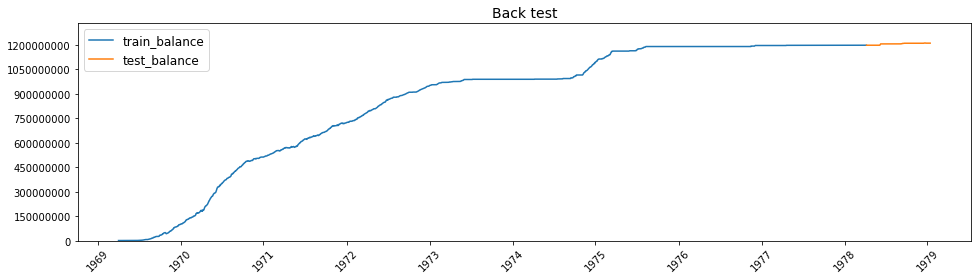

In [5]:
# 損益計算
df_concat = pd.concat([df_train_result, df_test_result])

df_back_test = trade_simulation(df_concat,leverage,start_balance)
df_back_test.to_csv('../output/df_back_test.csv', encoding='cp932',index=True)

# Back test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_concat[df_back_test['is_train']]['Date'], df_back_test[df_back_test['is_train']]['balance'], label='train_balance')
ax.plot(df_concat[~df_back_test['is_train']]['Date'], df_back_test[~df_back_test['is_train']]['balance'], label='test_balance')
ax.legend(fontsize=12)
ax.set_title('Back test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_back_test['balance'].max() + df_back_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, df_back_test['balance'].max() + 1000000, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_back_test.iloc[0]['Date']))
print('最終日: {}'.format(df_back_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)-start_balance))

#### Forward test

C:\Users\naofumi.honda\Anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\naofumi.honda\Anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


初日: 2020-01-02
最終日: 2021-02-02
最終日時点の残高: 2857674
儲け: 1857674


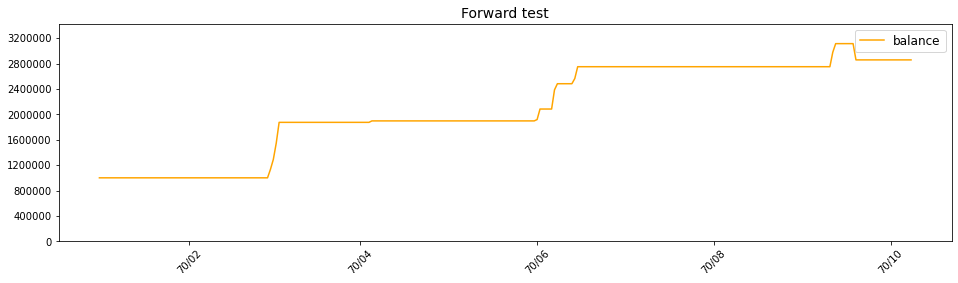

In [6]:
# 損益計算
df_forward_test = trade_simulation(df_test_result,leverage,start_balance)
df_forward_test.to_csv('../output/df_forward_test.csv', encoding='cp932',index=True)

# Forward test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_forward_test['Date'], df_forward_test['balance'], label='balance', color='orange')
ax.legend(fontsize=12)
ax.set_title('Forward test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_forward_test['balance'].max() + df_forward_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, 5000001, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_forward_test.iloc[0]['Date']))
print('最終日: {}'.format(df_forward_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)-start_balance))